From linear models to machine learning
===
- Machine learning can be intimidating, but all of the most complex concepts can be broken down into single, less complex chunks. The complexity from ML techniques emerges when we take simple blocks and chain them together.
- No technique embodies this more from neural networks - powerful universal function approximators, driving the current state of the art in ML.
- Broken down to their simplest unit, the 'neuron', these networks are nothing more than combinations of simple non-linear units, with the emergent complexity coming from chaining arbitrary numbers of them together. This is not helped by current ML frameworks abstracting this away under `Layer` APIs and wrapping the entire training process under `model.fit()` or similar.

- This notebook starts off in (hopefully) familiar territory of linear models (straight line fits), and builds on these to build simple neural networks from scratch.
- We will use the [JAX]() linear algebra framework to power this, essentially `numpy`-like syntax, but with powerful automatic differentiation and compilation routines. This can provide C-level performance, but with the nice programming experience we're all familiar with

In this notebook:
- We will build and train from scratch a simple neural network, to demystify the process and build intuition for how such networks work, train, and classify.
- We will apply this neural network to astronomical data.
- Features, feature extraction, PCA

In [60]:
import jax
jax.config.update("jax_enable_x64", True)  # force JAX to use 64-bit mode
jnp = jax.numpy

# init our RNG key, for later.
rng_key = jax.random.PRNGKey(42)

import matplotlib.pyplot as plt

Linear models
---
Let's start right at the beginning, with among the simplest statistical regression models that comes to mind.

The first step is to generate a test dataset - see below:

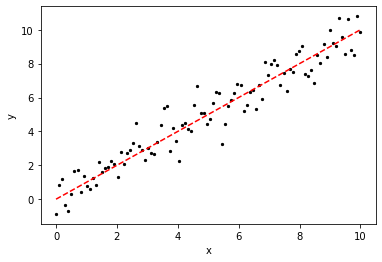

In [61]:
x = jnp.linspace(0, 10, 100)
m_true = 1
b_true = 0

y_true = m_true * x + b_true
y_obs = y_true + jax.random.normal(rng_key, shape=x.shape)

plt.scatter(x, y_obs, c='k', s=5)
plt.plot(x, y_true, c='r', ls='--')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Analytic solution
---
In the case of linear models, we're lucky that an analytic solution exists -- linear least squares.
We can write the model above as a matrix equation.

Note in the cells below, the `@` operator is infix notation to denote matrix multiplication. You can read `a @ b` as `np.matmul(a, b)` if it helps with understanding.

In [62]:
design_matrix = jnp.array([jnp.ones_like(x), x]).T
obs_matrix = y_obs[jnp.newaxis, :].T

In [63]:
# Thankfully, there's a convenience function to compute this for us
coeffs, _, _, _ = jnp.linalg.lstsq(design_matrix, obs_matrix)

# Essentially this does the below under the hood - the `lstsq` function does things more cleverly to avoid singular matrices and speeds things up with Cholesky decomposition
coeffs_handcoded = jnp.linalg.inv(design_matrix.T @ design_matrix) @ design_matrix.T @ obs_matrix

for c in coeffs.flatten():
    print(f"{c:.3f}")

0.205
0.972


Some observations
---
- Note that we do not exactly recover the coefficients we put in (i.e. `m_true`, `b_true`) in the cell where we create the dataset. This is because we added noise, and least squares works on overdetermined problems.

Numerical solution
---
- Sometimes we may not have linear solutions to our problems - i.e. in the most general case, any non-separable model is significantly more difficult to solve. Here we need to turn to iterative methods.

- In the following section, we introduce a few concepts which we'll come back to continually through this workshop. Don't worry if you don't fully follow now, we'll come back to these and elaborate further.

In [65]:
def linear_model(pars, x, y):
    m, c = pars
    return m*x + c

def loss_function(pars: list, x: jnp.ndarray, y: jnp.ndarray):
    y_model = linear_model(pars, x, y)
    return jnp.mean(jnp.square(y - y_model))

For this section, let's analytically compute the derivatives! Don't worry, this is just to show you what's going on - `JAX` can do this automatically for us going forward.

In [69]:
def dloss_dm(pars, x, y):
    m, c = pars
    y_model = linear_model(pars, x, y)
    return -2 * jnp.mean((y_obs - y_model)*x)

def dloss_dc(pars, x, y):
    m, c = pars
    y_model = linear_model(pars, x, y)
    return -2 * jnp.mean((y_obs - y_model))

# to make this easier to follow, let's write a function that returns these as an array.
def dloss_vec(pars, x, y):
    dldm = dloss_dm(pars, x, y)
    dldc = dloss_dc(pars, x, y)

    return jnp.array([dldm, dldc])

Gradient descent
---
- We now have a loss function, and gradients of it with respect to our parameters. Now to optimise the parameters using gradient descent.

In [106]:
m_init = 0
c_init = 1
init_pars = jnp.array([m_init, c_init])
_pars = init_pars

eta = 1e-3
n_optimisation_steps = 3000

loss_arr = jnp.zeros(n_optimisation_steps)
grad_arr = jnp.zeros(n_optimisation_steps)

for n in range(n_optimisation_steps):
    _loss = loss_function(_pars, x, y_obs)
    loss_arr = loss_arr.at[n].set(_loss)

    _loss_grads = dloss_vec(_pars, x, y_obs)
    grad_arr = grad_arr.at[n].set(jnp.linalg.norm(_loss_grads))
    _pars -= eta * _loss_grads

    if not (n % 100):
        print(f"{n} steps: loss {_loss:.3f} / gradnorm: {jnp.linalg.norm(_loss_grads):.3f}")

0 steps: loss 25.197 / gradnorm: 57.724
100 steps: loss 0.859 / gradnorm: 0.442
200 steps: loss 0.841 / gradnorm: 0.418
300 steps: loss 0.824 / gradnorm: 0.398
400 steps: loss 0.809 / gradnorm: 0.379
500 steps: loss 0.796 / gradnorm: 0.360
600 steps: loss 0.783 / gradnorm: 0.343
700 steps: loss 0.772 / gradnorm: 0.326
800 steps: loss 0.762 / gradnorm: 0.310
900 steps: loss 0.753 / gradnorm: 0.295
1000 steps: loss 0.744 / gradnorm: 0.281
1100 steps: loss 0.737 / gradnorm: 0.268
1200 steps: loss 0.730 / gradnorm: 0.255
1300 steps: loss 0.724 / gradnorm: 0.242
1400 steps: loss 0.718 / gradnorm: 0.231
1500 steps: loss 0.713 / gradnorm: 0.219
1600 steps: loss 0.709 / gradnorm: 0.209
1700 steps: loss 0.705 / gradnorm: 0.199
1800 steps: loss 0.701 / gradnorm: 0.189
1900 steps: loss 0.697 / gradnorm: 0.180
2000 steps: loss 0.694 / gradnorm: 0.171
2100 steps: loss 0.692 / gradnorm: 0.163
2200 steps: loss 0.689 / gradnorm: 0.155
2300 steps: loss 0.687 / gradnorm: 0.147
2400 steps: loss 0.685 / g

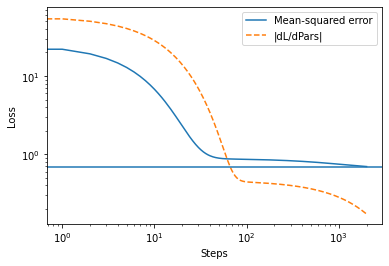

In [105]:
analytic_loss = loss_function([m_true, b_true], x, y_obs)

plt.plot(loss_arr, label='Mean-squared error')
plt.plot(grad_arr, ls='--', label='|dL/dPars|')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.axhline(analytic_loss)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()